In [89]:
# Current test dataset scrape and load works, but not to build a sufficient model 

    # select and narrow down input features for model
        # features from live dataset:
            # [1] order size
            # [2] time (may not be used or extremely difficult to factor in)
        # potential calcuated features to be added alongside input:
            # [3] order position from execution point/"spread"
            # [4] order size delta from last update
        # potential features from additional API input:    
            # [5] extract candlestick data for the last hour or 15 minutes
                # calc overall slope/trend for that hour
                # factor in support and resistance points for candles with long wicks for that hour
                    # establish those zones as potential breakpoints
                    # as current price approaches those breakpoints, weight size more in model     
                # Use TA-lib wrapper to auto establish support and resistance zones for the 15 minute/1 hour chart
                    # (https://github.com/mrjbq7/ta-lib)
                    
            # Not using in current implementation:
                # [6] severe hashrate changes  ("https://blockchain.info/q/hashrate")
                    # if hashrate for total network has sharp change down, buy walls likely to encouter less resistance
                    # assumed negative correlation
                    # put in range to prevent small changes from overinfluencing model
                # [7] severe unconfirmed tx ("https://blockchain.info/q/unconfirmedcount")
                    # similar to [6], except that with sharp increase up, sell walls likely to encouter less resistance
                    # assumed positive correlation
                    # put in range to prevent small changes from overinfluencing model

        # Calculate orderbook states from L2 updates
            # pick interval between applying l2update to last updated snapshot
            # 5 minutes, 15 minutes
            
    # Model selection
        # Supervised = feature[x1,x2,x3....], target[y]
            # features[x] --> variables with predictive power

            # Supervised (output value or label is known) 
            #--------> method actually being used here is technically technically pseudo-supervised/directed supervised learning
                # 1D CNN/2D (position and size of orderbook)
                # LSTM/GRU
                    # regression vs classification example difference : 
                        #predicting price as value over time vs. price direction over time
                         
        # Reinforcement learning ---> categorial cross entropy of likelyhood that this "wall" is STRONG or WEAK
            # i.e. supported or not suppported; don't know exactly outcome [y]
                # but still able to predict an assumed categorical class class []
                    
###########################
        
        # UPDATE CYCLE: EVERY 15 MINUTES 
            # [position,size,size delta]
                #features= [position,size,size delta]
                    # algorithm sets y variable labels based upon prexisting historical data 
                    # logistic classification: [strong, weak, fake, real]
                        # "known relationship" -> identify class that the data belongs 
                        # Technically pseudo-labeling/semi-supervised learning approach ##
            # set [y] variable to true or scale from 0-1 for all orders near key S/R areas for past 15 min
                # TA-lib library + numpy + pandas = should be able to do this
         
        # pull websocket l2/snapshot data + candlesticks for past 15 minutes
            # apply scale or label to l2 
                # scale updated upon position change or next l2 update (15 minute sync)
                
                
###########################

###Model design
        # model = Sequential()
    ###INPUT LAYER
        ## [samples,timesteps,features] ##
        # samples = data rows
        
        # timesteps
            # How long in time each sample is; 
                # if feeding in 15 minutes, then 15 ticks?
                # 1 timestep in what context is defined as what, precisely?
        # features = features
            
        # model.add(LSTM(2))
        # model.add(Dense(1))
    ###OUTPUT LAYER
        # Softmax activation 
        # One node per class value if one hot encoded input         
            
###########################           

In [90]:
# Imports
import pandas as pd
import numpy as np
import json
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

# Charting-specific imports
import matplotlib.finance
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
from matplotlib.finance import volume_overlay,volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance

import requests
import gdax
    # Python setup.py install with environment activaated to install/use
    # Do not use default gdax pip install package - that version of the package is currently broken

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras import backend as K

#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)


# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib


In [91]:
# Historic rates 15 minute basis example
# Build 15 minute chart from this data - time series olhc&vol data

public_client = gdax.PublicClient()
chart_1hr =public_client.get_product_historic_rates('BTC-USD', granularity=3600) 
chart_15m =public_client.get_product_historic_rates('BTC-USD', granularity=900)
    # 900 seconds = 15 minutes,  # 3600 seconds = 1 hour
    # Potentially compare to 6h/1d as overall reference for uptrend/downtrend short term
    # Structure of response: 
        # [ time, low, high, open, close, volume ]
        
    # Pass start and end date/time as unix timestamp for past hour
    # Dates in unix/ISO_8601 format: https://en.wikipedia.org/wiki/ISO_8601

In [92]:
# Convert chart data response into dataframes
chart_1hr_df =pd.DataFrame.from_records(chart_1hr,columns=["time","low", "high","open" ,  "close", "volume"])
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,  "close", "volume"])

In [93]:
### Currently not used as potential input features ###

# Current hashrate and unconfirmed TX from blockchain.info
    # limit quests to a maximum of 1 every 10 seconds.
    
# Estimated hashrate in gigahash
#response = requests.get("https://blockchain.info/q/hashrate")
#print(response.json())

# Number of pending unconfirmed transactions
##response2 = requests.get("https://blockchain.info/q/unconfirmedcount")
#print(response2.json())

In [94]:
# start/end time from request log
request_log_df= pd.read_csv("test_data/request_log.csv")
#Convert iso in request log to correct datetime format
request_log_df['iso'] = pd.to_datetime(request_log_df['iso'])
print(request_log_df.head())

      Unnamed: 0                     iso         epoch
0    request end 2018-04-17 01:05:03.469  1.523927e+09
1  request start 2018-04-17 00:55:03.354  1.523927e+09


In [95]:
chart_15m_df.head()

,time,low,high,open,close,volume
0,1524183720,8354.98,8354.99,8354.98,8354.99,5.050013
1,1524183660,8354.98,8354.99,8354.99,8354.98,6.846906
2,1524183600,8349.99,8354.99,8350.00,8354.99,20.689127
3,1524183540,8347.73,8350.00,8347.73,8350.00,62.014771
4,1524183480,8341.01,8347.72,8341.01,8347.72,9.752146


In [96]:
# Reorder columns according to label order required by matplotlib finance package
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]
chart_15m_df.head()

,time,open,high,low,close,volume
0,1524183720,8354.98,8354.99,8354.98,8354.99,5.050013
1,1524183660,8354.99,8354.99,8354.98,8354.98,6.846906
2,1524183600,8350.00,8354.99,8349.99,8354.99,20.689127
3,1524183540,8347.73,8350.00,8347.73,8350.00,62.014771
4,1524183480,8341.01,8347.72,8341.01,8347.72,9.752146


In [97]:
# Reverse/sort timestamp order (without reversal chart labels will be out of order)
chart_15m_df.sort_values(by='time',axis=0, inplace =True)

In [98]:
chart_15m_df.head()

,time,open,high,low,close,volume
299,1524165780,8250.00,8250.0,8249.99,8249.99,2.728098
298,1524165840,8250.00,8250.0,8249.99,8250.00,1.515616
297,1524165900,8250.00,8250.0,8249.99,8249.99,3.755159
296,1524165960,8250.00,8250.0,8249.99,8250.00,1.814224
295,1524166020,8249.99,8250.0,8249.99,8250.00,33.489204


In [99]:
#Convert/sort time to datetime object (for matplotlib chart format requirement)
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')
chart_15m_df.head()

,time,open,high,low,close,volume
299,2018-04-19 19:23:00,8250.00,8250.0,8249.99,8249.99,2.728098
298,2018-04-19 19:24:00,8250.00,8250.0,8249.99,8250.00,1.515616
297,2018-04-19 19:25:00,8250.00,8250.0,8249.99,8249.99,3.755159
296,2018-04-19 19:26:00,8250.00,8250.0,8249.99,8250.00,1.814224
295,2018-04-19 19:27:00,8249.99,8250.0,8249.99,8250.00,33.489204


In [100]:
# Auto support/resistance adapted into function
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
# from pandas_datareader import data, wb
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

def autoSR(dataframe):
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
    return ml_results

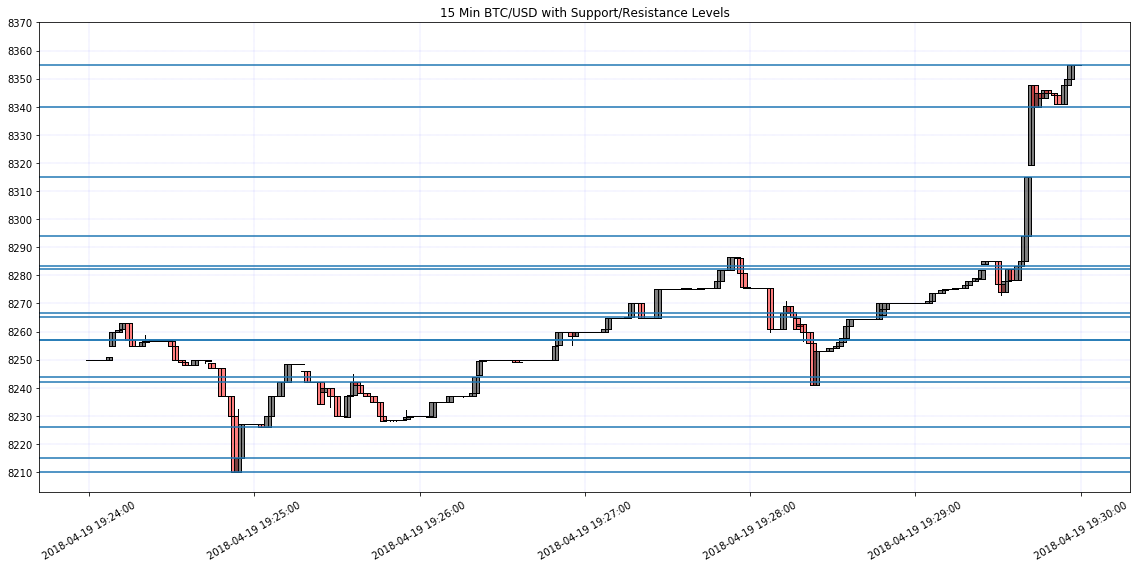

In [101]:
# Generate chart of past 15 minutes with autogenerated support and resistance levels:
fig, ax = plt.subplots(figsize=(16, 8)
                     )
candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],chart_15m_df['low'],chart_15m_df['close'],width=2,\
                  colorup='k',colordown='r',alpha=.5)
ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
plt.yticks(np.arange(min(chart_15m_df['low']), max(chart_15m_df['high'])+20, 10))
#ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='--', linewidth='0.1', color='b')
matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
#volume_overlay2(chart_15m_df['close'],chart_15m_df['volume'],width=1,colorup='k',colordown='r',alpha=1)
ml_results = autoSR(chart_15m_df)
for k in ml_results:
    plt.axhline(y=k)
plt.tight_layout()
plt.show()

In [102]:
print("Auto generated support and resistance levels for past 15 minutes:")
print(ml_results)

Auto generated support and resistance levels for past 15 minutes:
[8210.01, 8215.12, 8226.17, 8242.02, 8244.0, 8256.82, 8256.92, 8265.01, 8266.63, 8282.09, 8283.41, 8293.93, 8315.14, 8340.03, 8354.99]


In [103]:
snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv")
snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv")
l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'changes':object})
request_log_df= pd.read_csv("test_data/request_log.csv")
snapshot_both_df = pd.concat([snapshot_asks_df,snapshot_bids_df], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

In [104]:
# Test add of features as columnsto dataset

# Set inital size delta l2 snapshot
snapshot_asks_df['size_delta'] = 0
snapshot_bids_df['size_delta'] = 0
# Set inital position for l2 snapshot
snapshot_asks_df['position'] = snapshot_asks_df.index +1
snapshot_bids_df['position'] = snapshot_bids_df.index +1
# Reverse index for sell/asks
#napshot_asks_df =snapshot_asks_df[::-1]
# Reverse inital position indicator for bids/buy side
rev = snapshot_bids_df['position'].values * -1
snapshot_bids_df['position'] = rev

In [105]:
snapshot_asks_df.tail()

,side,price,size,size_delta,position
16992,sell,6.794720e+09,0.000174,0,16993
16993,sell,9.719374e+09,0.001000,0,16994
16994,sell,9.987654e+09,0.001049,0,16995
16995,sell,1.000000e+10,0.014000,0,16996
16996,sell,1.000000e+10,0.028392,0,16997


In [106]:
snapshot_bids_df.head()

,side,price,size,size_delta,position
0,buy,8042.90,9.118009,0,-1
1,buy,8042.83,0.002487,0,-2
2,buy,8042.50,0.420000,0,-3
3,buy,8042.00,0.001000,0,-4
4,buy,8041.33,0.020000,0,-5


In [107]:
# Autogenerated support/resistance past 15 minutes
print("Auto generated support and resistance levels for past 15 minutes:")
print(ml_results)

Auto generated support and resistance levels for past 15 minutes:
[8210.01, 8215.12, 8226.17, 8242.02, 8244.0, 8256.82, 8256.92, 8265.01, 8266.63, 8282.09, 8283.41, 8293.93, 8315.14, 8340.03, 8354.99]


In [108]:
# Set inital proximity to autogenerated S/R levels
snapshot_asks_df['sr_proximity'] = 0 
snapshot_bids_df['sr_proximity'] = 0

In [109]:
# Convert ml_results into sorted int array
ml_results_modified =np.asarray(ml_results)
#ml_results_modified =np.trunc(ml_results_modified).astype(int)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
ml_results_modified 

array([8210.01, 8215.12, 8226.17, 8242.02, 8244.  , 8256.82, 8256.92,
       8265.01, 8266.63, 8282.09, 8283.41, 8293.93, 8315.14, 8340.03,
       8354.99])

In [110]:
# min - 10%
# max + 10%
# remove duplicates from above list
# median/mode average
# proximity to closest

# take price and subtract from every single line
    # store differences in array
    # take lowest absolute value number signed [ml_results -price]
        # array of signed differences 
        # then take absolute value -proximity

In [111]:
# Set inital proximity feature for l2 snapshot within +30/-30 range
#snapshot_asks_df =snapshot_asks_df[::-1]
for i in range(len(snapshot_asks_df['price'])):
    
    #print(snapshot_asks_df['price'])
    print(snapshot_asks_df['price'].values[i])
    
    if snapshot_asks_df['price'].values[i] in ml_results_modified:
        
        #print(snapshot_asks_df['price'].values[i])
        snapshot_asks_df['sr_proximity'].values[i] =1
        
    if snapshot_asks_df['price'].values[i] in ml_results_modified-10:
        snapshot_asks_df['sr_proximity'].values[i] = -1
    if snapshot_asks_df['price'].values[i] in ml_results_modified+10:
        snapshot_asks_df['sr_proximity'].values[i] = 2
    if snapshot_asks_df['price'].values[i] in ml_results_modified-20:
        snapshot_asks_df['sr_proximity'].values[i] = -2
    if snapshot_asks_df['price'].values[i] in ml_results_modified+20:
        snapshot_asks_df['sr_proximity'].values[i] = 3
    if snapshot_asks_df['price'].values[i] in ml_results_modified-30:
        snapshot_asks_df['sr_proximity'].values[i] = -3
    if snapshot_asks_df['price'].values[i] in ml_results_modified+30:
        snapshot_asks_df['sr_proximity'].values[i] = 4 
for i in range(len(snapshot_bids_df['price'])):
    if snapshot_bids_df['price'].values[i] in ml_results_modified:
        #print(snapshot_bids_df['price'].values[i])
        snapshot_bids_df['sr_proximity'].values[i] =1    
    if snapshot_bids_df['price'].values[i] in ml_results_modified-10:
        snapshot_bids_df['sr_proximity'].values[i] = -1
    if snapshot_bids_df['price'].values[i] in ml_results_modified+10:
        snapshot_bids_df['sr_proximity'].values[i] = 2
    if snapshot_bids_df['price'].values[i] in ml_results_modified-20:
        snapshot_bids_df['sr_proximity'].values[i] = -2
    if snapshot_bids_df['price'].values[i] in ml_results_modified+20:
        snapshot_bids_df['sr_proximity'].values[i] = 3
    if snapshot_bids_df['price'].values[i] in ml_results_modified-30:
        snapshot_bids_df['sr_proximity'].values[i] = -3
    if snapshot_bids_df['price'].values[i] in ml_results_modified+30:
        snapshot_bids_df['sr_proximity'].values[i] = 4   
     

8042.91
8042.92
8042.93
8042.94
8042.95
8043.0
8043.9
8043.99
8044.0
8044.06
8044.34
8044.53
8044.62
8044.9
8045.0
8045.12
8045.18
8045.36
8045.46
8045.52
8045.54
8045.55
8045.75
8046.0
8046.03
8046.31
8046.59
8046.87
8047.0
8047.12
8047.15
8047.44
8047.49
8047.72
8048.0
8048.28
8048.56
8048.64
8048.84
8048.99
8049.0
8049.06
8049.13
8049.24
8049.37
8049.41
8049.48
8049.56
8049.69
8049.97
8050.0
8050.25
8050.53
8050.59
8050.75
8050.82
8051.0
8051.1
8051.24
8051.38
8051.58
8051.62
8051.66
8051.94
8052.0
8052.22
8052.5
8052.51
8052.6
8052.73
8052.79
8053.0
8053.06
8053.07
8053.08
8053.35
8053.63
8053.92
8054.0
8054.2
8054.65
8054.67
8054.95
8055.0
8055.1
8055.12
8055.13
8056.0
8056.06
8056.56
8056.77
8057.0
8057.47
8057.5
8057.61
8058.0
8058.31
8058.38
8058.49
8058.99
8059.0
8059.58
8059.86
8060.0
8060.48
8060.8
8061.0
8061.23
8061.41
8062.0
8062.04
8062.1
8062.3
8062.5
8062.61
8062.77
8063.0
8063.01
8063.06
8064.0
8064.04
8064.06
8064.09
8064.18
8064.21
8064.22
8064.55
8064.93
8065.0
806

8418.46
8418.61
8418.94
8419.0
8419.6
8419.75
8419.99
8420.0
8420.09
8420.16
8421.0
8422.25
8422.31
8422.53
8422.61
8422.99
8424.0
8424.13
8424.76
8424.99
8425.0
8425.09
8425.2
8425.26
8425.74
8426.02
8426.13
8426.14
8426.57
8426.61
8426.97
8427.0
8427.72
8427.99
8428.0
8428.44
8428.66
8428.95
8429.0
8429.05
8429.4
8429.71
8429.76
8429.77
8429.93
8429.99
8430.0
8430.18
8430.2
8430.31
8430.49
8430.61
8431.03
8431.72
8432.0
8432.1
8432.26
8432.49
8432.61
8432.94
8432.99
8433.0
8433.08
8434.0
8434.5
8434.51
8434.61
8434.77
8434.78
8434.99
8435.0
8435.04
8435.23
8435.48
8435.54
8435.8
8436.0
8436.66
8436.72
8436.92
8436.98
8437.0
8437.99
8438.0
8438.61
8438.96
8439.79
8439.8
8439.94
8439.98
8439.99
8440.0
8441.11
8441.6
8441.95
8442.0
8442.06
8442.27
8442.54
8442.59
8442.61
8442.99
8443.63
8443.75
8443.96
8444.0
8444.44
8444.47
8444.8
8445.0
8445.6
8445.63
8445.64
8446.0
8446.61
8447.0
8447.04
8447.89
8447.99
8448.0
8448.78
8448.97
8449.0
8449.81
8449.96
8449.98
8449.99
8450.0
8450.02
8450

9091.67
9092.0
9092.29
9092.31
9092.95
9093.29
9094.0
9094.17
9094.99
9095.0
9095.38
9096.0
9096.2
9096.65
9097.3
9098.0
9098.34
9098.35
9098.4
9099.0
9099.01
9099.99
9100.0
9100.12
9100.37
9100.62
9100.88
9100.96
9101.0
9101.05
9101.06
9101.1
9101.45
9101.67
9102.31
9103.35
9103.49
9104.0
9105.0
9105.75
9106.99
9107.0
9107.32
9108.0
9108.1
9108.24
9108.36
9108.97
9110.0
9110.13
9111.0
9111.11
9111.53
9111.68
9111.91
9112.3
9112.33
9112.6
9113.06
9114.4
9114.99
9115.42
9115.56
9116.0
9116.26
9117.34
9117.53
9118.37
9118.8
9119.04
9120.0
9120.14
9121.95
9122.0
9122.11
9122.35
9122.62
9122.68
9123.0
9123.1
9123.45
9124.0
9124.46
9124.99
9125.0
9125.45
9126.0
9126.2
9127.36
9127.71
9127.8
9127.97
9128.38
9128.5
9128.88
9129.0
9129.27
9130.0
9130.15
9130.27
9131.31
9131.44
9132.37
9132.4
9132.87
9132.94
9133.0
9134.0
9135.0
9135.88
9136.0
9136.98
9137.38
9138.0
9138.12
9138.39
9139.2
9139.34
9139.45
9139.78
9140.0
9140.16
9140.32
9140.46
9140.54
9141.61
9142.39
9142.94
9143.0
9143.53
9144.

9803.75
9804.01
9804.12
9804.78
9804.88
9804.89
9804.98
9805.0
9805.57
9805.92
9807.34
9808.0
9808.44
9808.48
9808.76
9809.06
9810.0
9810.83
9810.94
9811.02
9811.41
9811.99
9812.0
9812.35
9812.93
9813.49
9813.7
9814.71
9814.83
9814.9
9815.0
9815.72
9816.73
9817.0
9817.36
9817.74
9818.0
9818.5
9818.75
9818.82
9819.0
9819.07
9819.94
9820.0
9820.84
9821.42
9822.37
9823.0
9823.3
9823.51
9824.91
9825.0
9826.95
9827.0
9827.38
9827.9
9828.25
9828.52
9829.0
9829.08
9830.0
9830.85
9831.43
9832.35
9832.39
9833.53
9833.96
9834.0
9834.92
9835.0
9835.59
9837.4
9838.54
9838.75
9838.87
9839.09
9840.0
9840.35
9840.86
9840.97
9841.44
9842.41
9842.53
9842.76
9843.55
9843.68
9843.87
9844.05
9844.1
9844.61
9845.0
9845.99
9846.65
9847.0
9847.42
9847.9
9847.97
9847.98
9848.0
9848.56
9849.0
9849.1
9849.11
9849.2
9850.0
9850.87
9850.9
9851.0
9851.45
9852.0
9852.43
9853.57
9853.66
9853.76
9854.0
9854.03
9854.79
9854.94
9854.99
9855.0
9855.05
9855.14
9856.0
9857.44
9858.58
9858.74
9858.82
9859.11
9859.85
9859.9

10430.0
10431.12
10431.71
10432.0
10432.82
10433.0
10434.28
10434.42
10434.88
10435.0
10435.72
10437.0
10437.81
10438.39
10438.9
10439.73
10440.0
10440.69
10443.74
10444.0
10444.17
10444.29
10444.43
10444.44
10444.66
10445.0
10447.0
10447.14
10447.49
10447.75
10449.0
10449.99
10450.0
10451.01
10451.76
10454.3
10454.44
10455.0
10455.77
10457.12
10457.25
10457.38
10458.0
10459.5
10459.78
10460.0
10460.06
10461.43
10463.41
10463.79
10464.31
10464.45
10465.76
10467.0
10467.45
10467.8
10469.0
10470.33
10471.09
10471.81
10472.0
10472.99
10474.11
10474.32
10474.4
10474.46
10475.0
10475.82
10476.12
10477.77
10477.99
10478.0
10479.0
10479.83
10480.0
10481.55
10483.27
10483.32
10483.44
10483.84
10484.0
10484.33
10484.47
10484.49
10485.0
10487.85
10488.0
10488.43
10488.69
10488.88
10489.0
10490.0
10491.86
10492.0
10492.51
10492.9
10494.0
10494.34
10494.44
10494.48
10495.0
10495.09
10495.52
10495.87
10496.1
10496.56
10498.0
10498.76
10498.99
10499.0
10499.49
10499.88
10499.96
10499.99
10500.0
1050

11455.0
11455.55
11457.03
11457.79
11458.0
11458.45
11459.0
11459.35
11459.68
11459.71
11460.0
11460.6
11462.0
11462.46
11462.62
11463.75
11464.01
11464.35
11464.8
11464.91
11465.0
11465.76
11465.99
11466.0
11468.99
11469.0
11469.9
11470.0
11470.01
11470.38
11471.37
11472.11
11473.0
11474.01
11474.73
11474.83
11475.0
11475.22
11476.4
11476.57
11477.0
11477.05
11477.35
11477.77
11478.0
11478.01
11478.04
11479.0
11479.74
11479.77
11480.0
11480.26
11480.84
11480.85
11482.0
11483.0
11483.28
11483.35
11484.0
11484.75
11484.84
11484.92
11485.0
11485.08
11485.2
11485.44
11485.68
11485.73
11486.81
11487.0
11487.12
11487.15
11487.33
11488.0
11488.88
11488.95
11489.0
11489.06
11489.55
11489.76
11489.89
11490.0
11490.02
11491.0
11491.13
11492.0
11492.45
11492.83
11493.0
11493.78
11494.42
11494.77
11494.81
11494.85
11495.0
11495.88
11496.14
11496.16
11496.82
11497.0
11497.31
11497.67
11497.69
11498.0
11498.26
11498.5
11498.92
11498.98
11499.0
11499.01
11499.07
11499.77
11499.78
11499.88
11499.95
1

12313.39
12320.0
12321.07
12321.2
12323.5
12324.56
12324.95
12325.0
12327.0
12327.13
12329.97
12330.0
12332.59
12333.0
12333.33
12333.72
12336.0
12337.33
12338.32
12340.0
12342.0
12344.99
12345.0
12345.66
12345.67
12345.69
12345.8
12347.0
12348.01
12348.43
12349.0
12349.92
12350.0
12350.12
12351.0
12357.0
12359.35
12360.6
12360.93
12363.32
12364.0
12365.0
12366.0
12366.28
12367.0
12368.89
12369.86
12369.98
12374.0
12375.0
12376.53
12377.99
12379.0
12382.0
12386.0
12390.0
12392.59
12395.0
12396.3
12397.0
12398.0
12399.0
12399.98
12399.99
12400.0
12401.0
12401.1
12401.77
12408.0
12410.46
12410.48
12411.0
12414.0
12415.0
12420.0
12422.97
12429.85
12430.0
12430.86
12434.0
12434.34
12435.0
12435.34
12440.0
12443.18
12444.0
12444.44
12445.99
12447.0
12448.0
12449.0
12449.69
12449.99
12450.0
12451.0
12452.0
12453.35
12453.74
12455.0
12457.0
12459.0
12460.0
12461.25
12463.0
12464.65
12466.37
12467.0
12467.23
12469.16
12469.32
12469.9
12470.88
12472.84
12474.0
12475.0
12477.77
12480.0
12480.6
1

14814.36
14814.8
14815.39
14816.32
14816.46
14818.0
14818.38
14820.0
14821.0
14821.22
14823.86
14824.42
14825.0
14825.27
14826.09
14828.22
14828.44
14828.53
14830.0
14834.49
14838.5
14840.0
14841.0
14842.42
14844.0
14844.4
14845.09
14845.55
14847.6
14848.04
14848.56
14849.72
14850.0
14855.0
14856.0
14858.62
14860.63
14863.23
14864.0
14864.06
14865.0
14865.31
14868.68
14869.38
14873.0
14874.0
14875.0
14877.0
14878.0
14878.74
14879.1
14879.76
14880.0
14882.0
14884.91
14884.98
14885.0
14886.86
14887.0
14888.0
14888.44
14888.53
14888.88
14889.01
14889.76
14890.0
14895.0
14897.03
14898.0
14898.72
14898.95
14899.0
14899.99
14900.0
14900.61
14901.1
14902.24
14905.16
14906.09
14907.0
14908.92
14910.0
14910.02
14912.0
14913.96
14914.28
14915.0
14918.98
14921.0
14923.0
14925.88
14926.0
14926.25
14928.36
14929.0
14929.04
14929.89
14932.0
14932.5
14933.0
14934.94
14935.0
14935.66
14937.36
14937.84
14939.1
14939.73
14940.0
14943.73
14944.0
14945.0
14946.0
14946.21
14948.97
14949.0
14949.16
14949.49

16680.0
16680.58
16682.15
16683.64
16684.0
16687.0
16688.88
16689.54
16690.0
16690.36
16693.0
16698.0
16698.94
16699.6
16699.99
16700.0
16700.01
16701.1
16702.0
16702.2
16703.83
16706.91
16709.0
16709.66
16710.0
16711.09
16712.9
16714.25
16719.72
16720.0
16720.83
16721.0
16722.22
16723.0
16723.01
16724.75
16725.0
16725.01
16726.74
16727.51
16729.78
16731.0
16731.71
16732.06
16737.0
16738.0
16738.66
16739.84
16741.97
16743.0
16744.0
16745.0
16746.4
16749.9
16749.99
16750.0
16756.73
16758.11
16759.0
16759.96
16762.68
16763.0
16766.76
16769.41
16770.02
16773.0
16775.8
16776.0
16777.0
16778.92
16779.88
16780.0
16780.08
16781.0
16782.0
16782.72
16783.93
16785.0
16785.9
16787.0
16788.0
16789.0
16789.42
16790.0
16790.11
16790.14
16790.39
16790.43
16791.0
16792.0
16792.21
16793.32
16794.87
16799.0
16799.98
16799.99
16800.0
16800.2
16800.54
16801.1
16802.62
16802.76
16803.14
16805.0
16808.0
16809.0
16809.17
16810.26
16811.39
16815.0
16816.96
16819.0
16820.32
16823.0
16824.15
16829.0
16829.27
16

18099.12
18099.91
18099.99
18100.0
18101.1
18103.87
18109.0
18109.31
18111.0
18118.15
18120.0
18121.0
18122.0
18122.72
18128.22
18128.26
18129.83
18132.4
18133.0
18138.76
18138.97
18144.99
18149.0
18149.31
18149.59
18149.89
18149.98
18150.0
18161.0
18172.0
18173.0
18174.99
18175.09
18180.0
18183.0
18187.77
18190.2
18193.0
18195.97
18196.0
18197.0
18197.03
18199.0
18199.12
18199.99
18200.0
18201.1
18203.52
18211.0
18214.87
18215.0
18215.61
18221.25
18227.0
18227.27
18230.0
18231.0
18231.14
18232.0
18232.85
18233.0
18234.0
18234.51
18235.91
18236.05
18236.38
18236.41
18236.52
18236.8
18238.83
18243.0
18244.0
18245.0
18245.5
18249.99
18250.0
18256.02
18259.0
18260.0
18263.95
18264.0
18264.81
18267.71
18267.79
18267.85
18267.87
18272.85
18273.0
18275.0
18275.69
18275.8
18277.0
18277.22
18279.99
18282.08
18288.0
18290.0
18295.0
18295.97
18299.0
18299.99
18300.0
18300.01
18301.1
18301.13
18301.2
18302.0
18304.88
18305.05
18308.0
18311.95
18311.99
18315.0
18319.99
18320.0
18321.0
18321.09
183

22176.02
22193.59
22198.0
22199.0
22199.03
22200.0
22221.2
22222.0
22222.22
22249.99
22250.0
22264.93
22275.0
22280.0
22288.0
22299.03
22300.0
22311.0
22318.88
22322.02
22333.0
22350.0
22356.6
22374.99
22375.0
22394.0
22399.03
22400.0
22440.0
22444.44
22448.37
22450.0
22461.24
22478.0
22480.0
22482.52
22487.87
22490.0
22495.0
22496.0
22497.99
22499.03
22499.1
22499.42
22499.99
22500.0
22515.0
22518.88
22534.89
22540.23
22549.9
22550.0
22552.0
22560.0
22599.03
22600.0
22617.11
22620.05
22624.99
22632.19
22647.0
22650.0
22654.0
22699.03
22700.0
22711.0
22718.88
22724.23
22735.0
22744.33
22749.99
22750.0
22767.0
22799.03
22800.0
22806.0
22809.0
22816.38
22826.43
22845.0
22850.0
22855.0
22873.0
22874.99
22888.0
22894.0
22899.03
22900.0
22908.61
22910.0
22918.0
22918.88
22937.12
22950.0
22953.52
22965.0
22977.0
22980.0
22980.47
22995.0
22997.96
22997.99
22999.0
22999.04
22999.99
23000.0
23000.23
23000.94
23014.26
23043.9
23050.0
23084.0
23093.36
23099.03
23100.0
23118.88
23123.0
23126.0
231

In [115]:
# Check to make sure proximity set worked
snapshot_asks_df.loc[snapshot_asks_df['sr_proximity'] == 1]

,side,price,size,size_delta,position,sr_proximity
830,sell,8244.00,0.002,0,831,1
947,sell,8283.41,0.079,0,948,1
1031,sell,8315.14,0.010,0,1032,1
1160,sell,8354.99,1.041,0,1161,1


In [116]:
# Check to make sure proximity set worked
snapshot_asks_df.loc[snapshot_asks_df['sr_proximity'] == -1]

,side,price,size,size_delta,position,sr_proximity
696,sell,8200.01,0.083218,0,697,-1
803,sell,8234.00,0.011400,0,804,-1
1124,sell,8344.99,0.015000,0,1125,-1


In [117]:
# Check to make sure proximity set worked
snapshot_asks_df.loc[snapshot_asks_df['sr_proximity'] == 2]

,side,price,size,size_delta,position,sr_proximity
861,sell,8254.00,0.002,0,862,2
1201,sell,8364.99,0.041,0,1202,2


In [114]:
# 16885 0
snapshot_asks_df.count()

side            16997
price           16997
size            16997
size_delta      16997
position        16997
sr_proximity    16997
dtype: int64